In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import config as c
from model import MLP_Discriminator

## モデルの定義と学習済み重みの読み込み

In [3]:
# weightのpath (0が正常、1が異常で学習済みの重み)
weight_path = "../weights/Dis_highest_performance__iter_1440_epoch_159.pth"

# GPU利用可能か否かの判定
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# モデル定義
D = MLP_Discriminator(in_dim=784)  # in_dim=512

# weightの読み込み
D.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))

D = nn.DataParallel(D, device_ids=[0])
print("Dis. on GPU => {}".format(next(D.parameters()).is_cuda))
if c.DEVICE == "cuda":
    torch.backends.cudnn.benchmark = c.CUDNN_BENCH

D.eval()

Dis. on GPU => True


DataParallel(
  (module): MLP_Discriminator(
    (layer1): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer2): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (last): Sequential(
      (0): Linear(in_features=512, out_features=1, bias=False)
    )
  )
)

## データローダの作成

In [4]:
import os
import torch.utils.data as data
from torchvision import transforms, datasets

def make_test_dataloader():
    nor_cat, ano_cat = c.NORMAL_CATEGOLY, c.ANOMALOUS_CATEGOLY  # config.pyで指定されている
    mean, std = c.MEAN, c.STD  # config.pyで指定されている
    bs_test = 4  # Testデータのミニバッチサイズ
    
    path = c.DATASET_PATH  # "../data"  # config.pyで指定されている
    is_dir = os.path.isdir(path)
    print("../data/ ディレクトリの存在 = {}".format(is_dir))
    if is_dir:  # もし"/data"ディレクトリが無ければ作る
        pass
    else:
        os.makedirs(path)
        
    dataset =datasets.MNIST(root=path, train=False, download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)]))
    mask = (dataset.targets == nor_cat) | (dataset.targets == ano_cat)
    dataset.data = dataset.data[mask]
    dataset.targets = dataset.targets[mask]
    
    # データローダの作成
    dataloader = data.DataLoader(dataset=dataset, batch_size=bs_test, shuffle=True, drop_last=True) # 端数は落とす

    return dataloader

# create Data Loader
dataloader = make_test_dataloader()


../data/ ディレクトリの存在 = True


## 画像の読み込みと確認

torch.Size([4, 1, 28, 28])
labels = [0 1 1 0]


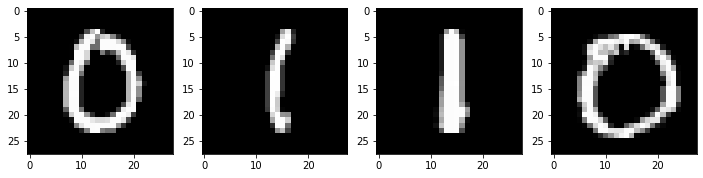

In [5]:
# データローダをイテレータに
dataiter = iter(dataloader)

# 次のミニバッチを取得
images, labels = dataiter.next()

# 画像表示のための関数定義
def show_images(images):
    fig = plt.figure(figsize=(12, 6))
    for i in range(0, 4):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i][0].numpy(), "gray")

# お試し
print(images.size())
show_images(images)
print("labels = {}".format(labels.numpy()))

## 異常検知のための関数定義

In [6]:
import time

def anomaly_detection(images, D_trained, threshold):
    results = [] 
    time_pred_start = time.time()
    
    with torch.no_grad():
        anomaly_score = - D_trained(images.view(-1, 28*28).to(c.DEVICE))
    
    time_pred_end = time.time()
    pred_time = time_pred_end - time_pred_start
    
    anomaly_score = anomaly_score.squeeze()
    anomaly_score = anomaly_score.cpu().detach().numpy().tolist()
    
    for i in range(len(anomaly_score)):
        if anomaly_score[i] > threshold:
            results.append("Anomalous")
        else:
            results.append("Normal")
    
    anomaly_score_round = [round(anomaly_score[n], 5) for n in range(len(anomaly_score))] 
    print("Anomaly Scores : {}".format(anomaly_score_round))
    print("Results        : {}".format(results))
    print("Pred time: {:.6f} sec".format(pred_time))
    
    return anomaly_score


# 異常検知

labels = [0 1 1 0]
Anomaly Scores : [-0.49549, 1.42144, 1.34613, -0.24059]
Results        : ['Normal', 'Anomalous', 'Anomalous', 'Normal']
Pred time: 0.002072 sec


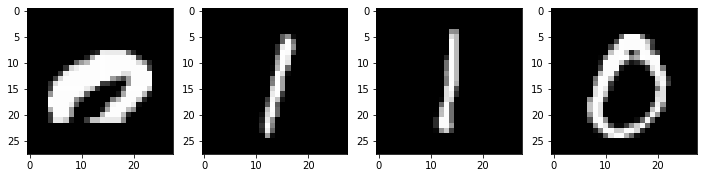

In [29]:
######### 異常スコアの閾値設定 #########
threshold = 0.0
######################################

# 次のミニバッチを取得
images, labels = dataiter.next()

# 画像表示
show_images(images)
# MNISTのラベル表示
print("labels = {}".format(labels.numpy()))
# 異常検知(0が正常、1が異常)
score = anomaly_detection(images, D, threshold=threshold)